# 1、Import Data

In [1]:
import pandas as pd
import statsmodels.stats.api as sms
from termcolor import colored, cprint
import statsmodels.formula.api as smf
import numpy as np
import scipy.stats as stats

In [2]:
## Import Dataset ##

# read excel
file_path = '/Users/sarah/Desktop/Aeon combine dataset.xlsx'
excel_file = pd.ExcelFile(file_path)

# create empty dataframe
combined_df = pd.DataFrame()

# read each sheet and combined to combined_df
for sheet_name in excel_file.sheet_names:
    # read each sheet first cell
    first_cell = pd.read_excel(excel_file, sheet_name=sheet_name, nrows=1, header=None).iloc[0, 0]
    
    # read "Non Salesday" and "非繁忙時段"
    sales_day = 'No' if 'Non Salesday' in str(first_cell) else 'Yes'
    peak = 'No' if '非繁忙時段' in str(first_cell) else 'Yes'
    
    # read sheet data from the second row
    df = pd.read_excel(excel_file, sheet_name=sheet_name, header=1)
    
    # add PEAK and SALES_DAY columns
    df['PEAK'] = peak
    df['SALES_DAY'] = sales_day
    
    # combined all datasets
    combined_df = pd.concat([combined_df, df], ignore_index=True)

# creat a new combined excel
output_file_path = 'Aeon combine dataset-2.xlsx'
combined_df.to_excel(output_file_path, index=False)

In [3]:
## Adding Member & SALES column ##

# define member or non-member with a new column "MEMBER"
member = []
for i in range(len(combined_df)):
    if pd.isna(combined_df["會員ID (N)"][i]) == True:
        member.append("No")
    else:
        member.append("Yes")
        
combined_df["MEMBER"] = member

# calculating the sum of product sales for each transaction "SALES"
sales = []
for i in range(len(combined_df)):
    product_sales = combined_df['銷售價'][i]*combined_df['數量'][i]
    sales.append(product_sales)
    
combined_df["SALES"] = sales

# add PB column 
pb = []
for i in range(len(combined_df)):
    if combined_df['商品名稱'][i].startswith('TV') == True:
        pb.append("PB")
    else:
        pb.append("Non-PB")
combined_df["PB"] = pb

combined_df

,門店編碼,銷售單號(N),DEPARTMENT名稱,SECTION,SECTION名稱,商品名稱,貨號 (N),銷售價,數量,會員ID (N),PEAK,SALES_DAY,MEMBER,SALES,PB
0,1,****9038854327,HOUSEHOLD & EA,165,LIVING APPLIANCE,TURBO 男士鼻毛剪套裝 THT200,***30522908,208.0,1,*******2027995,Yes,Yes,Yes,208.0,Non-PB
1,1,****9038864013,HOUSEHOLD & EA,165,LIVING APPLIANCE,伊瑪子母燉盅 ISP16,***00769141,290.0,1,NaN,Yes,Yes,No,290.0,Non-PB
2,1,****9038867517,FASHION,118,UNDERWEAR,TV158SA5303H PFWM綿 男裝V領長袖內衣 BK L,***12490298,79.0,1,*******1758861,Yes,Yes,Yes,79.0,PB
3,1,****9038867517,FASHION,118,UNDERWEAR,TV158SA5403H PFWM綿 男裝圓領長袖內衣 CGY L,***12490488,79.0,1,*******1758861,Yes,Yes,Yes,79.0,PB
4,1,****9038880116,FOOD & DELICA,133,DELICA,炸蒜照燒雞扒便當,***00405852,39.9,1,NaN,Yes,Yes,No,39.9,Non-PB
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
87615,12,****8985588706,FOOD & DELICA,131,GROCERY,福字 米粉5包裝,***02900124,22.9,1,NaN,No,Yes,No,22.9,Non-PB
87616,12,****8985658528,FOOD & DELICA,134,DAILY,榮鈦行 糯米雞,***02036077,38.9,1,NaN,No,Yes,No,38.9,Non-PB
87617,12,****8985658528,FOOD & DELICA,131,GROCERY,SURF BEVERAGE 香印提子綠茶,***20486981,9.9,1,NaN,No,Yes,No,9.9,Non-PB
87618,12,****8985720217,HOUSEHOLD & EA,171,NON FOOD,維達4D DELUXE袋裝面紙5包裝(天然無香),***30270300,27.5,1,NaN,No,Yes,No,27.5,Non-PB


# 2、Sales Analysis

In [4]:
# sales of PB and Non-PB goods
combined_df.groupby(["PB"])["SALES"].sum().to_frame().rename(index={"PB": "PB"})

,SALES
PB,
Non-PB,5034204.5
PB,309577.9


In [5]:
PBsales_ratio = round((combined_df.loc[combined_df["PB"]=="PB"]["SALES"].sum() / combined_df["SALES"].sum()) * 100, 2)
print(f"The sales percentage of PB is {PBsales_ratio}%.")

The sales percentage of PB is 5.79%.


## 2.1 Sales analysis by stores

In [6]:
# calculate PB and Non-PB Quantity
pivot_df = combined_df.groupby(["門店編碼", "PB"]).agg({"數量": "sum"}) \
    .pivot_table(index="門店編碼", columns="PB", values="數量").rename_axis("QUANTITY", axis=1)

# calculate sales by stores
pivot_df['Total_Sales_Quantity'] = pivot_df.sum(axis=1)

# calculate % of PB in total sales by stores 
pivot_df['% of PB Sales Quantity to Total'] = (pivot_df['PB'] / pivot_df['Total_Sales_Quantity']) * 100

pivot_df = pivot_df[['Non-PB', 'PB', 'Total_Sales_Quantity', '% of PB Sales Quantity to Total']]
pivot_df

QUANTITY,Non-PB,PB,Total_Sales_Quantity,% of PB Sales Quantity to Total
門店編碼,,,,
1,27223,1160,28383,4.086953
2,10473,601,11074,5.427127
3,2719,195,2914,6.691833
4,4977,276,5253,5.254140
5,7860,489,8349,5.856989
6,5202,366,5568,6.573276
7,17135,883,18018,4.900655
8,11881,579,12460,4.646870
9,9197,347,9544,3.635792


In [7]:
# calculate PB and Non-PB Sales
pivot_df = combined_df.groupby(["門店編碼", "PB"]).agg({"SALES": "sum"}) \
    .pivot_table(index="門店編碼", columns="PB", values="SALES").rename_axis("SALES", axis=1)

# calculate sales by stores
pivot_df['Total_Sales'] = pivot_df.sum(axis=1)

# calculate % of PB in total sales by stores 
pivot_df['% of PB Sales to Total'] = (pivot_df['PB'] / pivot_df['Total_Sales']) * 100

pivot_df = pivot_df[['Non-PB', 'PB', 'Total_Sales', '% of PB Sales to Total']]
pivot_df

SALES,Non-PB,PB,Total_Sales,% of PB Sales to Total
門店編碼,,,,
1,1374759.3,63452.9,1438212.2,4.411929
2,539887.8,35584.2,575472.0,6.183481
3,56742.5,6269.5,63012.0,9.949692
4,207958.6,17119.1,225077.7,7.605862
5,359403.3,28355.2,387758.5,7.312593
6,335367.9,23494.4,358862.3,6.546912
7,846020.9,47869.6,893890.5,5.355197
8,557483.7,38270.4,595754.1,6.423858
9,243117.4,14767.1,257884.5,5.726246


Store 3 has the highest % of PB sales quantity to total, and also to the sales. 

## 2.2 Sales analysis by department

### 2.2.1 General

In [8]:
# calculate PB and Non-PB Quantity
pivot_df = combined_df.groupby(["DEPARTMENT名稱", "PB"]).agg({"數量": "sum"}) \
    .pivot_table(index="DEPARTMENT名稱", columns="PB", values="數量").rename_axis("QUANTITY", axis=1)

# calculate sales by department 
pivot_df['Total_Sales_Quantity'] = pivot_df.sum(axis=1)

# calculate % of PB in total sales by department 
pivot_df['% of PB Sales Quantity to Total'] = (pivot_df['PB'] / pivot_df['Total_Sales_Quantity']) * 100

pivot_df = pivot_df[['Non-PB', 'PB', 'Total_Sales_Quantity', '% of PB Sales Quantity to Total']]
pivot_df

QUANTITY,Non-PB,PB,Total_Sales_Quantity,% of PB Sales Quantity to Total
DEPARTMENT名稱,,,,
BENTO & BAKERY,3533.0,NaN,3533.0,NaN
FASHION,6680.0,1780.0,8460.0,21.040189
FOOD & DELICA,73262.0,2336.0,75598.0,3.090029
HOUSEHOLD & EA,10075.0,1533.0,11608.0,13.206409
LIVING PLAZA,10651.0,NaN,10651.0,NaN
MISC-OTHER SALES,4814.0,NaN,4814.0,NaN
MISC-PACKING,2037.0,NaN,2037.0,NaN
MISCELLANEOUS,133.0,NaN,133.0,NaN
MOLLY FANTASY,1.0,NaN,1.0,NaN


In [9]:
# calculate PB and Non-PB Sales
pivot_df = combined_df.groupby(["DEPARTMENT名稱", "PB"]).agg({"SALES": "sum"}) \
    .pivot_table(index="DEPARTMENT名稱", columns="PB", values="SALES").rename_axis("SALES", axis=1)

# calculate sales by stores
pivot_df['Total_Sales'] = pivot_df.sum(axis=1)

# calculate % of PB in total sales by stores 
pivot_df['% of PB Sales to Total'] = (pivot_df['PB'] / pivot_df['Total_Sales']) * 100

pivot_df = pivot_df[['Non-PB', 'PB', 'Total_Sales', '% of PB Sales to Total']]
pivot_df

SALES,Non-PB,PB,Total_Sales,% of PB Sales to Total
DEPARTMENT名稱,,,,
BENTO & BAKERY,53518.4,NaN,53518.4,NaN
FASHION,926120.6,174409.7,1100530.3,15.847787
FOOD & DELICA,2236399.6,39734.1,2276133.7,1.745684
HOUSEHOLD & EA,1510436.2,95434.1,1605870.3,5.942827
LIVING PLAZA,134819.0,NaN,134819.0,NaN
MISC-OTHER SALES,94496.5,NaN,94496.5,NaN
MISC-PACKING,2037.0,NaN,2037.0,NaN
MISCELLANEOUS,76267.2,NaN,76267.2,NaN
MOLLY FANTASY,98.0,NaN,98.0,NaN


FASHION department has the highest % of PB Sales Quantity to Total, and the same as in sales.

### 2.2.2  HOUSEHOLD & EA

#### 2.2.2.1 Quantity VS Sales

In [10]:
# calculate PB and Non-PB Quantity
pivot_df = combined_df.loc[combined_df["DEPARTMENT名稱"] == "HOUSEHOLD & EA"].groupby(["SECTION名稱", "PB"]).agg({"數量": "sum"}) \
    .pivot_table(index="SECTION名稱", columns="PB", values="數量").rename_axis("QUANTITY", axis=1)

# calculate sales by department 
pivot_df['Total_Sales_Quantity'] = pivot_df.sum(axis=1)

# calculate % of PB in total sales by department 
pivot_df['% of PB Sales Quantity to Total'] = (pivot_df['PB'] / pivot_df['Total_Sales_Quantity']) * 100

pivot_df = pivot_df[['Non-PB', 'PB', 'Total_Sales_Quantity', '% of PB Sales Quantity to Total']]
pivot_df

QUANTITY,Non-PB,PB,Total_Sales_Quantity,% of PB Sales Quantity to Total
SECTION名稱,,,,
AUDIO VISUAL,147.0,NaN,147.0,NaN
BEDDING,568.0,93.0,661.0,14.069592
COSMETIC,1101.0,38.0,1139.0,3.336260
FURNITURE & INTERIOR,170.0,125.0,295.0,42.372881
HEALTH,588.0,85.0,673.0,12.630015
HOUSEKEEPING,845.0,388.0,1233.0,31.467964
KITCHEN & DINING,933.0,437.0,1370.0,31.897810
LIVING APPLIANCE,485.0,NaN,485.0,NaN
NATURAL,82.0,NaN,82.0,NaN


In [11]:
# calculate PB and Non-PB Sales
pivot_df = combined_df.loc[combined_df["DEPARTMENT名稱"] == "HOUSEHOLD & EA"].groupby(["SECTION名稱", "PB"]).agg({"SALES": "sum"}) \
    .pivot_table(index="SECTION名稱", columns="PB", values="SALES").rename_axis("SALES", axis=1)

# calculate sales by stores
pivot_df['Total_Sales'] = pivot_df.sum(axis=1)

# calculate % of PB in total sales by stores 
pivot_df['% of PB Sales to Total'] = (pivot_df['PB'] / pivot_df['Total_Sales']) * 100

pivot_df = pivot_df[['Non-PB', 'PB', 'Total_Sales', '% of PB Sales to Total']]
pivot_df

SALES,Non-PB,PB,Total_Sales,% of PB Sales to Total
SECTION名稱,,,,
AUDIO VISUAL,73747.3,NaN,73747.3,NaN
BEDDING,211994.5,20433.1,232427.6,8.791168
COSMETIC,85813.5,838.3,86651.8,0.967435
FURNITURE & INTERIOR,337516.3,16534.8,354051.1,4.670173
HEALTH,31106.5,3234.6,34341.1,9.419034
HOUSEKEEPING,67075.1,14510.9,81586.0,17.786017
KITCHEN & DINING,166767.2,28456.0,195223.2,14.576136
LIVING APPLIANCE,339063.8,NaN,339063.8,NaN
NATURAL,9140.2,NaN,9140.2,NaN


In "HOUSEHOLD & EA" department, the ratio of PB sales quantity in FURNITURE & INTERIOR section is the highest, but HOUSEKEEPING section has the highest ratio of PB sales.

#### 2.2.2.2 Top 10 products in  HOUSEHOLD & EA

In [12]:
# Top 10 in general 
combined_df.loc[combined_df["DEPARTMENT名稱"] == "HOUSEHOLD & EA"].groupby(by="商品名稱")\
.agg({"SECTION名稱": "first", "數量": "sum"}).sort_values(by="數量", ascending=False).head(10)

,SECTION名稱,數量
商品名稱,,
法國雙飛人 藥水,HEALTH,132
思詩樂嬰兒清潔消毒棉,NON FOOD,74
CONSIG.- TAKAGI TR,HOUSEKEEPING,69
高潔絲 純棉面層特長衛生護墊,NON FOOD,66
王子KA 4合1抗菌除蟎洗衣珠袋裝16G*40粒,NON FOOD,62
潔霸超濃縮殺菌洗衣棒 51支裝,NON FOOD,56
CONSIG.- MAIN PLAN,KITCHEN & DINING,56
BESTPRICE BY TOPVALU 軟包紙巾,NON FOOD,54
ADP PENTAGON,HOUSEKEEPING,52


In [13]:
# Top 10 in PB Brand 
combined_df[(combined_df["DEPARTMENT名稱"] == "HOUSEHOLD & EA") & (combined_df["PB"] == "PB")].groupby(by="商品名稱")\
.agg({"SECTION名稱": "first", "數量": "sum"}).sort_values(by="數量", ascending=False).head(10)

,SECTION名稱,數量
商品名稱,,
TVHC 除塵濕紙20片裝 (72),HOUSEKEEPING,23
TVBP 暖貼(標準) 30個裝,HEALTH,18
TVBP 暖包(標準) 30個裝,HEALTH,17
TVHC 陶瓷茶杯連碟 (6/36),KITCHEN & DINING,16
TVHC 除塵乾紙30片裝 (54),HOUSEKEEPING,16
TVHC 減少衣領變形衣架 (60),HOUSEKEEPING,15
TV 貓狗小食 減鹽乾沙丁魚仔,NON FOOD,15
TV 茉莉檀木香味防蛀防霉片 (掛裝) (24),HOUSEKEEPING,13
TVHC 鐵線衣架 (50/400),HOUSEKEEPING,13


In [14]:
# Top 10 in non-PB Brand
combined_df[(combined_df["DEPARTMENT名稱"] == "HOUSEHOLD & EA") & (combined_df["PB"] == "Non-PB")].groupby(by="商品名稱")\
.agg({"SECTION名稱": "first", "數量": "sum"}).sort_values(by="數量", ascending=False).head(10)

,SECTION名稱,數量
商品名稱,,
法國雙飛人 藥水,HEALTH,132
思詩樂嬰兒清潔消毒棉,NON FOOD,74
CONSIG.- TAKAGI TR,HOUSEKEEPING,69
高潔絲 純棉面層特長衛生護墊,NON FOOD,66
王子KA 4合1抗菌除蟎洗衣珠袋裝16G*40粒,NON FOOD,62
潔霸超濃縮殺菌洗衣棒 51支裝,NON FOOD,56
CONSIG.- MAIN PLAN,KITCHEN & DINING,56
BESTPRICE BY TOPVALU 軟包紙巾,NON FOOD,54
ADP PENTAGON,HOUSEKEEPING,52


In "HOUSEHOLD & EA" department, 法國雙飛人 藥水 sold quantity most.

#### 2.2.2.3 Top 5 products by section 

In [28]:
# get data when DEPARTMENT = "HOUSEHOLD & EA"
household_df = combined_df[combined_df["DEPARTMENT名稱"] == "HOUSEHOLD & EA"]

# count by each section & item
grouped_df = household_df.groupby(['SECTION名稱', '商品名稱'])['數量'].sum().reset_index()

# get top 5 items by each section
top5_items_df = grouped_df.sort_values(['SECTION名稱', '數量'], ascending=[True, False]) \
                          .groupby('SECTION名稱') \
                          .head(5) \
                          .reset_index(drop=True)

top5_items_df

,SECTION名稱,商品名稱,數量
0,AUDIO VISUAL,REE SCHEME(TR)-281,10
1,AUDIO VISUAL,REMAX 多功能數碼線收納盒RC-190 BL,8
2,AUDIO VISUAL,X3D HDMI CABLE HDMI-SS201,8
3,AUDIO VISUAL,REMAX 多功能數碼線收納盒RC-190 WH,7
4,AUDIO VISUAL,X3D RF CABLE RFC-S115,7
5,BEDDING,CONSIG.- WING YIP,36
6,BEDDING,CONSIG.- J-TEX (HK,32
7,BEDDING,CONSIG.- PANG TANG,31
8,BEDDING,CONSIG.- CASABLANCA BEDDING,28
9,BEDDING,"雅芳婷19""X29""抗病毒珍珠枕",25


In [15]:
# get data when DEPARTMENT = "HOUSEHOLD & EA" and Non-PB products
household_df = combined_df[(combined_df["DEPARTMENT名稱"] == "HOUSEHOLD & EA") & (combined_df["PB"] == "Non-PB")]

# count by each section & item
grouped_df = household_df.groupby(['SECTION名稱', '商品名稱'])['數量'].sum().reset_index()

# get top 5 items by each section
top5_items_df = grouped_df.sort_values(['SECTION名稱', '數量'], ascending=[True, False]) \
                          .groupby('SECTION名稱') \
                          .head(5) \
                          .reset_index(drop=True)

top5_items_df

,SECTION名稱,商品名稱,數量
0,AUDIO VISUAL,REE SCHEME(TR)-281,10
1,AUDIO VISUAL,REMAX 多功能數碼線收納盒RC-190 BL,8
2,AUDIO VISUAL,X3D HDMI CABLE HDMI-SS201,8
3,AUDIO VISUAL,REMAX 多功能數碼線收納盒RC-190 WH,7
4,AUDIO VISUAL,X3D RF CABLE RFC-S115,7
5,BEDDING,CONSIG.- WING YIP,36
6,BEDDING,CONSIG.- J-TEX (HK,32
7,BEDDING,CONSIG.- PANG TANG,31
8,BEDDING,CONSIG.- CASABLANCA BEDDING,28
9,BEDDING,"雅芳婷19""X29""抗病毒珍珠枕",25


In [16]:
# get data when DEPARTMENT = "HOUSEHOLD & EA" and PB products
household_df = combined_df[(combined_df["DEPARTMENT名稱"] == "HOUSEHOLD & EA") & (combined_df["PB"] == "PB")]

# count by each section & item
grouped_df = household_df.groupby(['SECTION名稱', '商品名稱'])['數量'].sum().reset_index()

# get top 5 items by each section
top5_items_df = grouped_df.sort_values(['SECTION名稱', '數量'], ascending=[True, False]) \
                          .groupby('SECTION名稱') \
                          .head(5) \
                          .reset_index(drop=True)

top5_items_df

,SECTION名稱,商品名稱,數量
0,BEDDING,TVHC 抑菌防臭酒店枕50×70CM (4),8
1,BEDDING,TVHC 抑菌防臭酒店枕43×63CM (4),5
2,BEDDING,TVHC PREMIUM記憶棉酒店枕 50CM (4),4
3,BEDDING,TVHC 冰涼雙面枕墊45CM灰色(90),2
4,BEDDING,TVHC 冰涼雙面枕袋50CM藍色(120),2
5,COSMETIC,TV 化妝棉,8
6,COSMETIC,TV 3層化妝棉,5
7,COSMETIC,TVBP 保濕潔面泡沫,4
8,COSMETIC,TV BP 卸妝紙,3
9,COSMETIC,TVBP 綿棒 200支×2 PACK,3


### 2.2.3 FOOD & DELICA

#### 2.2.3.1 Quantity VS Sales

In [17]:
# calculate PB and Non-PB Quantity
pivot_df = combined_df.loc[combined_df["DEPARTMENT名稱"] == "FOOD & DELICA"].groupby(["SECTION名稱", "PB"]).agg({"數量": "sum"}) \
    .pivot_table(index="SECTION名稱", columns="PB", values="數量").rename_axis("QUANTITY", axis=1)

# calculate sales by department 
pivot_df['Total_Sales_Quantity'] = pivot_df.sum(axis=1)

# calculate % of PB in total sales by department 
pivot_df['% of PB Sales Quantity to Total'] = (pivot_df['PB'] / pivot_df['Total_Sales_Quantity']) * 100

pivot_df = pivot_df[['Non-PB', 'PB', 'Total_Sales_Quantity', '% of PB Sales Quantity to Total']]
pivot_df

QUANTITY,Non-PB,PB,Total_Sales_Quantity,% of PB Sales Quantity to Total
SECTION名稱,,,,
DAILY,21246,1,21247,0.004707
DELICA,5859,88,5947,1.479738
FISH,3747,48,3795,1.264822
GROCERY,23892,1649,25541,6.456286
LIQUOR,915,192,1107,17.344173
MEAT,4850,316,5166,6.116918
PRODUCE,12753,42,12795,0.328253


In [18]:
# calculate PB and Non-PB Sales
pivot_df = combined_df.loc[combined_df["DEPARTMENT名稱"] == "FOOD & DELICA"].groupby(["SECTION名稱", "PB"]).agg({"SALES": "sum"}) \
    .pivot_table(index="SECTION名稱", columns="PB", values="SALES").rename_axis("SALES", axis=1)

# calculate sales by stores
pivot_df['Total_Sales'] = pivot_df.sum(axis=1)

# calculate % of PB in total sales by stores 
pivot_df['% of PB Sales to Total'] = (pivot_df['PB'] / pivot_df['Total_Sales']) * 100

pivot_df = pivot_df[['Non-PB', 'PB', 'Total_Sales', '% of PB Sales to Total']]
pivot_df

SALES,Non-PB,PB,Total_Sales,% of PB Sales to Total
SECTION名稱,,,,
DAILY,500675.2,37.9,500713.1,0.007569
DELICA,249787.1,1212.8,250999.9,0.483187
FISH,261755.6,1782.5,263538.1,0.676373
GROCERY,551657.0,23523.2,575180.2,4.089710
LIQUOR,65900.6,2742.5,68643.1,3.995303
MEAT,296775.5,9567.4,306342.9,3.123102
PRODUCE,309848.6,867.8,310716.4,0.279290


#### 2.2.3.2 Top 10 products in FOOD & DELICA

In [19]:
# Top 10 in general 
combined_df.loc[combined_df["DEPARTMENT名稱"] == "FOOD & DELICA"].groupby(by="商品名稱")\
.agg({"SECTION名稱": "first", "數量": "sum"}).sort_values(by="數量", ascending=False).head(10)

,SECTION名稱,數量
商品名稱,,
日本之惠 白蛋 10隻裝,DAILY,822
澳洲橙56庄,PRODUCE,544
澳洲 SWEETEST BATCH 珍寶藍莓,PRODUCE,537
燒味精選,DELICA,443
TOPVALU 香蕉 (越南產),PRODUCE,442
TOPVALU 北海道十勝?雪靜小粒納豆,DAILY,342
北海道3.6牛乳(迷你裝),DAILY,328
日清 咚兵衛腐皮烏冬,GROCERY,310
日本福岡秋香園本菇,PRODUCE,307


In [21]:
# Top 10 in PB Brand 
combined_df[(combined_df["DEPARTMENT名稱"] == "FOOD & DELICA") & (combined_df["PB"] == "PB")].groupby(by="商品名稱")\
.agg({"SECTION名稱": "first", "數量": "sum"}).sort_values(by="數量", ascending=False).head(10)

,SECTION名稱,數量
商品名稱,,
TV BP 醬汁炒麵,GROCERY,73
TV 西冷火腿 4x4P,MEAT,60
TV JAS特級粗挽豬肉維也納香腸 130G,MEAT,54
TVBP 油浸吞拿魚 單罐裝,GROCERY,45
TVBP 水浸吞拿魚 單罐裝,GROCERY,42
TV 綠豆寬粉,GROCERY,42
TV 忌廉薯餅(蟹肉)(2件),DELICA,37
TV BP 鹽味炒麵,GROCERY,34
TV 肉薯餅(2件),DELICA,34


In [22]:
# Top 10 in non-PB Brand
combined_df[(combined_df["DEPARTMENT名稱"] == "FOOD & DELICA") & (combined_df["PB"] == "Non-PB")].groupby(by="商品名稱")\
.agg({"SECTION名稱": "first", "數量": "sum"}).sort_values(by="數量", ascending=False).head(10)

,SECTION名稱,數量
商品名稱,,
日本之惠 白蛋 10隻裝,DAILY,822
澳洲橙56庄,PRODUCE,544
澳洲 SWEETEST BATCH 珍寶藍莓,PRODUCE,537
燒味精選,DELICA,443
TOPVALU 香蕉 (越南產),PRODUCE,442
TOPVALU 北海道十勝?雪靜小粒納豆,DAILY,342
北海道3.6牛乳(迷你裝),DAILY,328
日清 咚兵衛腐皮烏冬,GROCERY,310
日本福岡秋香園本菇,PRODUCE,307


#### 2.2.3.3 Top 5 products by section

In [27]:
# get data when DEPARTMENT = "FOOD & DELICA"
household_df = combined_df[combined_df["DEPARTMENT名稱"] == "FOOD & DELICA"]

# count by each section & item
grouped_df = household_df.groupby(['SECTION名稱', '商品名稱'])['數量'].sum().reset_index()

# get top 5 items by each section
top5_items_df = grouped_df.sort_values(['SECTION名稱', '數量'], ascending=[True, False]) \
                          .groupby('SECTION名稱') \
                          .head(5) \
                          .reset_index(drop=True)

top5_items_df

,SECTION名稱,商品名稱,數量
0,DAILY,日本之惠 白蛋 10隻裝,822
1,DAILY,TOPVALU 北海道十勝?雪靜小粒納豆,342
2,DAILY,北海道3.6牛乳(迷你裝),328
3,DAILY,蘭王雞蛋 10隻裝,258
4,DAILY,大阪王將 餃子(羽根),208
5,DELICA,燒味精選,443
6,DELICA,NC HOT FOOD,252
7,DELICA,BEST CITY HOT FOOD,249
8,DELICA,JIANZENG,224
9,DELICA,RW SIU MEI,222


In [24]:
# get data when DEPARTMENT = "FOOD & DELICA" and Non-PB products
household_df = combined_df[(combined_df["DEPARTMENT名稱"] == "FOOD & DELICA") & (combined_df["PB"] == "Non-PB")]

# count by each section & item
grouped_df = household_df.groupby(['SECTION名稱', '商品名稱'])['數量'].sum().reset_index()

# get top 5 items by each section
top5_items_df = grouped_df.sort_values(['SECTION名稱', '數量'], ascending=[True, False]) \
                          .groupby('SECTION名稱') \
                          .head(5) \
                          .reset_index(drop=True)

top5_items_df

,SECTION名稱,商品名稱,數量
0,DAILY,日本之惠 白蛋 10隻裝,822
1,DAILY,TOPVALU 北海道十勝?雪靜小粒納豆,342
2,DAILY,北海道3.6牛乳(迷你裝),328
3,DAILY,蘭王雞蛋 10隻裝,258
4,DAILY,大阪王將 餃子(羽根),208
5,DELICA,燒味精選,443
6,DELICA,NC HOT FOOD,252
7,DELICA,BEST CITY HOT FOOD,249
8,DELICA,JIANZENG,224
9,DELICA,RW SIU MEI,222


In [25]:
# get data when DEPARTMENT = "FOOD & DELICA" and PB products
household_df = combined_df[(combined_df["DEPARTMENT名稱"] == "FOOD & DELICA") & (combined_df["PB"] == "PB")]

# count by each section & item
grouped_df = household_df.groupby(['SECTION名稱', '商品名稱'])['數量'].sum().reset_index()

# get top 5 items by each section
top5_items_df = grouped_df.sort_values(['SECTION名稱', '數量'], ascending=[True, False]) \
                          .groupby('SECTION名稱') \
                          .head(5) \
                          .reset_index(drop=True)

top5_items_df

,SECTION名稱,商品名稱,數量
0,DAILY,TV BP 6種芝士火鍋 微波爐用,1
1,DELICA,TV 忌廉薯餅(蟹肉)(2件),37
2,DELICA,TV 肉薯餅(2件),34
3,DELICA,TV 肉屋薯餅,9
4,DELICA,TV 忌廉薯餅(蟹肉),7
5,DELICA,TV 肉屋薯餅(3件庄),1
6,FISH,TV FF 蒲燒鰻魚汁,10
7,FISH,TV 海鮮什錦 250G,9
8,FISH,TV BP 三杯醋水雲藻,5
9,FISH,TV MSC 多春魚 8P,4


### 2.2.4 FASHION

#### 2.2.4.1 Quantity VS Sales

In [30]:
# calculate PB and Non-PB Quantity
pivot_df = combined_df.loc[combined_df["DEPARTMENT名稱"] == "FASHION"].groupby(["SECTION名稱", "PB"]).agg({"數量": "sum"}) \
    .pivot_table(index="SECTION名稱", columns="PB", values="數量").rename_axis("QUANTITY", axis=1)

# calculate sales by department 
pivot_df['Total_Sales_Quantity'] = pivot_df.sum(axis=1)

# calculate % of PB in total sales by department 
pivot_df['% of PB Sales Quantity to Total'] = (pivot_df['PB'] / pivot_df['Total_Sales_Quantity']) * 100

pivot_df = pivot_df[['Non-PB', 'PB', 'Total_Sales_Quantity', '% of PB Sales Quantity to Total']]
pivot_df

QUANTITY,Non-PB,PB,Total_Sales_Quantity,% of PB Sales Quantity to Total
SECTION名稱,,,,
BABIES,1583.0,99.0,1682.0,5.885850
CHILDREN,1312.0,448.0,1760.0,25.454545
HOBBY,684.0,NaN,684.0,NaN
LADIES,352.0,160.0,512.0,31.250000
LADY'S ACCESSORY,225.0,NaN,225.0,NaN
MENS,394.0,123.0,517.0,23.791103
SHOES,31.0,NaN,31.0,NaN
SPORT,415.0,NaN,415.0,NaN
STATIONERY & PIMPLE,1065.0,NaN,1065.0,NaN


In [31]:
# calculate PB and Non-PB Sales
pivot_df = combined_df.loc[combined_df["DEPARTMENT名稱"] == "FASHION"].groupby(["SECTION名稱", "PB"]).agg({"SALES": "sum"}) \
    .pivot_table(index="SECTION名稱", columns="PB", values="SALES").rename_axis("SALES", axis=1)

# calculate sales by stores
pivot_df['Total_Sales'] = pivot_df.sum(axis=1)

# calculate % of PB in total sales by stores 
pivot_df['% of PB Sales to Total'] = (pivot_df['PB'] / pivot_df['Total_Sales']) * 100

pivot_df = pivot_df[['Non-PB', 'PB', 'Total_Sales', '% of PB Sales to Total']]
pivot_df

SALES,Non-PB,PB,Total_Sales,% of PB Sales to Total
SECTION名稱,,,,
BABIES,177994.4,9856.7,187851.1,5.247081
CHILDREN,186066.4,39882.0,225948.4,17.650933
HOBBY,96168.5,NaN,96168.5,NaN
LADIES,48882.4,32080.0,80962.4,39.623331
LADY'S ACCESSORY,46745.3,NaN,46745.3,NaN
MENS,45977.0,22497.0,68474.0,32.854806
SHOES,5091.0,NaN,5091.0,NaN
SPORT,95706.3,NaN,95706.3,NaN
STATIONERY & PIMPLE,61173.9,NaN,61173.9,NaN


#### 2.2.4.2 Top 10 products in FASHION

In [32]:
# Top 10 in general 
combined_df.loc[combined_df["DEPARTMENT名稱"] == "FASHION"].groupby(by="商品名稱")\
.agg({"SECTION名稱": "first", "數量": "sum"}).sort_values(by="數量", ascending=False).head(10)

,SECTION名稱,數量
商品名稱,,
CONSIG.- FRANK Y.,CHILDREN,254
CONSIG.- ASCO (HON,UNDERWEAR,194
CONSIG.- CHUN AU K,CHILDREN,123
CONSIG.- LORDIN AP,MENS,64
(CON) COMFORT HOME XMAS ITEMS,STATIONERY & PIMPLE,60
(CON) MOREKY MANIS COUNTER,STATIONERY & PIMPLE,57
CONSIG.- CHAN`S CO,STATIONERY & PIMPLE,52
CONSIG.- SUN KWONG BLK & WHT BTS SHOES,CHILDREN,48
(CON) SUP BOOKS,STATIONERY & PIMPLE,46


In [33]:
# Top 10 in PB Brand 
combined_df[(combined_df["DEPARTMENT名稱"] == "FASHION") & (combined_df["PB"] == "PB")].groupby(by="商品名稱")\
.agg({"SECTION名稱": "first", "數量": "sum"}).sort_values(by="數量", ascending=False).head(10)

,SECTION名稱,數量
商品名稱,,
TV161AA5113H 男童長袖內衣 WH 130,CHILDREN,9
TV161AA5153H 童裝厚地長袖內衣 WH 120CM,CHILDREN,8
TV161AA5133H 女童長袖內衣 WH 140,CHILDREN,8
TV161AA5153H 童裝厚地長袖內衣 WH 150,CHILDREN,8
TV161AA5113H 男童長袖內衣 WH 160,CHILDREN,8
TV153SA0682H PF WARM 女裝圓領長袖內衣 WH M,UNDERWEAR,7
TV153SA0682H PF WARM 女裝圓領長袖內衣 BE M,UNDERWEAR,7
TV153SA1353H PFWM綿 女裝短袖內衣 BE M,UNDERWEAR,7
TV161AA5153H 童裝厚地長袖內衣 WH 110,CHILDREN,7


In [34]:
# Top 10 in Non-PB Brand 
combined_df[(combined_df["DEPARTMENT名稱"] == "FASHION") & (combined_df["PB"] == "Non-PB")].groupby(by="商品名稱")\
.agg({"SECTION名稱": "first", "數量": "sum"}).sort_values(by="數量", ascending=False).head(10)

,SECTION名稱,數量
商品名稱,,
CONSIG.- FRANK Y.,CHILDREN,254
CONSIG.- ASCO (HON,UNDERWEAR,194
CONSIG.- CHUN AU K,CHILDREN,123
CONSIG.- LORDIN AP,MENS,64
(CON) COMFORT HOME XMAS ITEMS,STATIONERY & PIMPLE,60
(CON) MOREKY MANIS COUNTER,STATIONERY & PIMPLE,57
CONSIG.- CHAN`S CO,STATIONERY & PIMPLE,52
CONSIG.- SUN KWONG BLK & WHT BTS SHOES,CHILDREN,48
(CON) SUP BOOKS,STATIONERY & PIMPLE,46


#### 2.2.4.3 Top 5 products by section

In [36]:
# get data when DEPARTMENT = "FASHION"
household_df = combined_df[combined_df["DEPARTMENT名稱"] == "FASHION"]

# count by each section & item
grouped_df = household_df.groupby(['SECTION名稱', '商品名稱'])['數量'].sum().reset_index()

# get top 5 items by each section
top5_items_df = grouped_df.sort_values(['SECTION名稱', '數量'], ascending=[True, False]) \
                          .groupby('SECTION名稱') \
                          .head(5) \
                          .reset_index(drop=True)

top5_items_df

,SECTION名稱,商品名稱,數量
0,BABIES,CONSIG.- TURNWELL,45
1,BABIES,CONSIG.- SHUN SANG,36
2,BABIES,CONSIG.- BLISS & B,34
3,BABIES,CONSIG.- PROMINENT,23
4,BABIES,CONSIG.- WING TAT,21
5,CHILDREN,CONSIG.- FRANK Y.,236
6,CHILDREN,CONSIG.- CHUN AU K,110
7,CHILDREN,CONSIG.- SUN KWONG BLK & WHT BTS SHOES,48
8,CHILDREN,CONSIG.- CONNAN TR,31
9,CHILDREN,CONSIG.- LITTLE ANGEL BTS SHOES,29


In [37]:
# get data when DEPARTMENT = "FASHION" and Non-PB products
household_df = combined_df[(combined_df["DEPARTMENT名稱"] == "FASHION") & (combined_df["PB"] == "Non-PB")]

# count by each section & item
grouped_df = household_df.groupby(['SECTION名稱', '商品名稱'])['數量'].sum().reset_index()

# get top 5 items by each section
top5_items_df = grouped_df.sort_values(['SECTION名稱', '數量'], ascending=[True, False]) \
                          .groupby('SECTION名稱') \
                          .head(5) \
                          .reset_index(drop=True)

top5_items_df

,SECTION名稱,商品名稱,數量
0,BABIES,CONSIG.- TURNWELL,45
1,BABIES,CONSIG.- SHUN SANG,36
2,BABIES,CONSIG.- BLISS & B,34
3,BABIES,CONSIG.- PROMINENT,23
4,BABIES,CONSIG.- WING TAT,21
5,CHILDREN,CONSIG.- FRANK Y.,236
6,CHILDREN,CONSIG.- CHUN AU K,110
7,CHILDREN,CONSIG.- SUN KWONG BLK & WHT BTS SHOES,48
8,CHILDREN,CONSIG.- CONNAN TR,31
9,CHILDREN,CONSIG.- LITTLE ANGEL BTS SHOES,29


In [38]:
# get data when DEPARTMENT = "FASHION" and PB products
household_df = combined_df[(combined_df["DEPARTMENT名稱"] == "FASHION") & (combined_df["PB"] == "PB")]

# count by each section & item
grouped_df = household_df.groupby(['SECTION名稱', '商品名稱'])['數量'].sum().reset_index()

# get top 5 items by each section
top5_items_df = grouped_df.sort_values(['SECTION名稱', '數量'], ascending=[True, False]) \
                          .groupby('SECTION名稱') \
                          .head(5) \
                          .reset_index(drop=True)

top5_items_df

,SECTION名稱,商品名稱,數量
0,BABIES,TV123BSI5417 嬰兒即棄紙圍兜-動物,6
1,BABIES,TV124AA0623嬰兒純白背心內衣(3P) WH 100,4
2,BABIES,TV124AA5063 嬰兒長袖?衣(2P) LBL 90,4
3,BABIES,TV124AA5073 嬰兒長袖?衣(2P) GN 100,4
4,BABIES,TV123AHM4326嬰兒純水500ML,3
5,CHILDREN,TV161AA5113H 男童長袖內衣 WH 130,9
6,CHILDREN,TV161AA5113H 男童長袖內衣 WH 160,8
7,CHILDREN,TV161AA5133H 女童長袖內衣 WH 140,8
8,CHILDREN,TV161AA5153H 童裝厚地長袖內衣 WH 120CM,8
9,CHILDREN,TV161AA5153H 童裝厚地長袖內衣 WH 150,8


## 2.3 Membership Rate

### 2.3.1 General

In [41]:
# Total - Members VS Non-Members 
total_mem = combined_df.loc[combined_df["會員ID (N)"].notnull(), "銷售單號(N)"].nunique()
total_nonmem = combined_df.loc[combined_df["會員ID (N)"].isnull(), "銷售單號(N)"].nunique()

# PB - Members VS Non-Members
pb_mem = combined_df.loc[(combined_df["PB"] == "PB") & (combined_df["會員ID (N)"].notnull()), "銷售單號(N)"].nunique()
pb_nonmem = combined_df.loc[(combined_df["PB"] == "PB") & (combined_df["會員ID (N)"].isnull()), "銷售單號(N)"].nunique()

# Non-PB - Members VS Non-Members
nonpb_mem = combined_df.loc[(combined_df["PB"] == "Non-PB") & (combined_df["會員ID (N)"].notnull()), "銷售單號(N)"].nunique()
nonpb_nonmem = combined_df.loc[(combined_df["PB"] == "Non-PB") & (combined_df["會員ID (N)"].isnull()), "銷售單號(N)"].nunique()

# Creat Dataframe 
result_df = pd.DataFrame({
    "Category": ["Total Member", "Total Non-member", "PB Member", "PB Non-member", "Non-PB Member", "Non-PB Non-member"],
    "Count": [total_mem, total_nonmem, pb_mem, pb_nonmem, nonpb_mem, nonpb_nonmem]
})


result_df

,Category,Count
0,Total Member,8670
1,Total Non-member,17341
2,PB Member,1344
3,PB Non-member,1672
4,Non-PB Member,8072
5,Non-PB Non-member,16729


In [44]:
# Total Membership Rate
num_members_total = combined_df.loc[combined_df["會員ID (N)"].notnull(), "銷售單號(N)"].nunique()
total_invoices_total = combined_df["銷售單號(N)"].nunique()
membership_rate_total = (num_members_total / total_invoices_total) * 100

# PB Membership Rate
num_members_pb = combined_df.loc[(combined_df["PB"] == "PB") & (combined_df["會員ID (N)"].notnull()), "銷售單號(N)"].nunique()
total_invoices_pb = combined_df.loc[combined_df["PB"] == "PB", "銷售單號(N)"].nunique()
membership_rate_pb = (num_members_pb / total_invoices_pb) * 100

# Non-PB Membership Rate
num_members_nonpb = combined_df.loc[(combined_df["PB"] == "Non-PB") & (combined_df["會員ID (N)"].notnull()), "銷售單號(N)"].nunique()
total_invoices_nonpb = combined_df.loc[combined_df["PB"] == "Non-PB", "銷售單號(N)"].nunique()
membership_rate_nonpb = (num_members_nonpb / total_invoices_nonpb) * 100


Membership_rate_df = pd.DataFrame({
    "Category": ["Total", "PB", "Non-PB"],
    "Membership Rate (%)": [membership_rate_total, membership_rate_pb, membership_rate_nonpb]
})


Membership_rate_df

,Category,Membership Rate (%)
0,Total,33.557826
1,PB,44.562334
2,Non-PB,32.552325


In [45]:
# Total - Members VS Non-Members ave. Sales 
total_sales_mem = combined_df.loc[combined_df["會員ID (N)"].notnull(), "SALES"].sum()
num_mem = combined_df.loc[combined_df["會員ID (N)"].notnull(), "銷售單號(N)"].nunique()
avg_sales_mem = total_sales_mem / num_mem

total_sales_nonmem = combined_df.loc[combined_df["會員ID (N)"].isnull(), "SALES"].sum()
num_nonmem = combined_df.loc[combined_df["會員ID (N)"].isnull(), "銷售單號(N)"].nunique()
avg_sales_nonmem = total_sales_nonmem / num_nonmem

# PB - Members VS Non-Members ave. Sales 
pb_sales_mem = combined_df.loc[(combined_df["PB"] == "PB") & (combined_df["會員ID (N)"].notnull()), "SALES"].sum()
num_mem_pb = combined_df.loc[(combined_df["PB"] == "PB") & (combined_df["會員ID (N)"].notnull()), "銷售單號(N)"].nunique()
avg_sales_mem_pb = pb_sales_mem / num_mem_pb

pb_sales_nonmem = combined_df.loc[(combined_df["PB"] == "PB") & (combined_df["會員ID (N)"].isnull()), "SALES"].sum()
num_nonmem_pb = combined_df.loc[(combined_df["PB"] == "PB") & (combined_df["會員ID (N)"].isnull()), "銷售單號(N)"].nunique()
avg_sales_nonmem_pb = pb_sales_nonmem / num_nonmem_pb

# Non-PB Membership Rate ave. Sales
nonpb_sales_mem = combined_df.loc[(combined_df["PB"] == "Non-PB") & (combined_df["會員ID (N)"].notnull()), "SALES"].sum()
num_mem_nonpb = combined_df.loc[(combined_df["PB"] == "Non-PB") & (combined_df["會員ID (N)"].notnull()), "銷售單號(N)"].nunique()
avg_sales_mem_nonpb = nonpb_sales_mem / num_mem_nonpb

nonpb_sales_nonmem = combined_df.loc[(combined_df["PB"] == "Non-PB") & (combined_df["會員ID (N)"].isnull()), "SALES"].sum()
num_nonmem_nonpb = combined_df.loc[(combined_df["PB"] == "Non-PB") & (combined_df["會員ID (N)"].isnull()), "銷售單號(N)"].nunique()
avg_sales_nonpb = nonpb_sales_nonmem / num_nonmem_nonpb


ave_sales_df = pd.DataFrame({
    "Category": ["Total Member", "Total Non-member", "PB Member", "PB Non-member", "Non-PB Member", "Non-PB Non-member"],
    "Average Sales": [avg_sales_mem, avg_sales_nonmem, avg_sales_mem_pb, avg_sales_nonmem_pb, avg_sales_mem_nonpb, avg_sales_nonpb]
})

ave_sales_df

,Category,Average Sales
0,Total Member,261.228155
1,Total Non-member,177.552292
2,PB Member,116.754762
3,PB Non-member,91.303529
4,Non-PB Member,261.140944
5,Non-PB Non-member,174.922279


In [47]:
# T-test
def t_test(group1, group2):
    t_stat, p_val = stats.ttest_ind(group1, group2, nan_policy='omit')
    return t_stat, p_val

# Total - Members VS Non-Members T-test 
total_mem_sales = combined_df.loc[combined_df["會員ID (N)"].notnull(), "SALES"]
total_nonmem_sales = combined_df.loc[combined_df["會員ID (N)"].isnull(), "SALES"]
t_stat_total, p_val_total = t_test(total_mem_sales, total_nonmem_sales)

# PB - Members VS Non-Members T-test 
pb_mem_sales = combined_df.loc[(combined_df["PB"] == "PB") & (combined_df["會員ID (N)"].notnull()), "SALES"]
pb_nonmem_sales = combined_df.loc[(combined_df["PB"] == "PB") & (combined_df["會員ID (N)"].isnull()), "SALES"]
t_stat_pb, p_val_pb = t_test(pb_mem_sales, pb_nonmem_sales)

# Non-PB - Members VS Non-Members T-test 
nonpb_mem_sales = combined_df.loc[(combined_df["PB"] == "Non-PB") & (combined_df["會員ID (N)"].notnull()), "SALES"]
nonpb_nonmem_sales = combined_df.loc[(combined_df["PB"] == "Non-PB") & (combined_df["會員ID (N)"].isnull()), "SALES"]
t_stat_nonpb, p_val_nonpb = t_test(nonpb_mem_sales, nonpb_nonmem_sales)


t_test_df = pd.DataFrame({
    "Category": ["Total", "PB", "Non-PB"],
    "T-Statistic": [t_stat_total, t_stat_pb, t_stat_nonpb],
    "P-Value": [p_val_total, p_val_pb, p_val_nonpb]
})


t_test_df

,Category,T-Statistic,P-Value
0,Total,9.088849,1.021075e-19
1,PB,7.198840,7.065889e-13
2,Non-PB,8.484226,2.206669e-17


### 2.3.2 Membership rate and sales across stores

In [49]:
def calculate_membership_rate(df):
    total_sales_count = df["銷售單號(N)"].nunique()
    member_sales_count = df.loc[df["會員ID (N)"].notnull(), "銷售單號(N)"].nunique()
    membership_rate = (member_sales_count / total_sales_count) * 100 if total_sales_count > 0 else 0
    return membership_rate

# membership rate by Stores 
store_groups = combined_df.groupby('門店編碼')

membership_rates = []

for store, group in store_groups:
    total_rate = calculate_membership_rate(group)
    pb_rate = calculate_membership_rate(group[group['PB'] == 'PB'])
    nonpb_rate = calculate_membership_rate(group[group['PB'] == 'Non-PB'])
    
    membership_rates.append({
        "門店編碼": store,
        "Total Membership Rate": total_rate,
        "PB Membership Rate": pb_rate,
        "Non-PB Membership Rate": nonpb_rate
    })

membership_rate_df = pd.DataFrame(membership_rates)

membership_rate_df

,門店編碼,Total Membership Rate,PB Membership Rate,Non-PB Membership Rate
0,1,37.563870,51.088777,36.557853
1,2,36.132418,43.333333,35.344459
2,3,17.851959,20.000000,17.851740
3,4,34.061135,42.948718,32.932470
4,5,40.774125,55.752212,39.010989
5,6,32.037325,37.765957,31.463415
6,7,39.169500,54.017857,37.761006
7,8,29.546242,43.260188,28.431373
8,9,24.115756,36.725664,22.879464
9,10,30.464135,44.961240,29.242820


In [68]:
# recognize Member VS Non-Member
combined_df['會員身份'] = combined_df['會員ID (N)'].notnull().map({True: 'Member', False: 'Non-member'})

# calculate average sales
def calculate_avg_sales(group):
    return group['SALES'].sum() / group['銷售單號(N)'].nunique() if group['銷售單號(N)'].nunique() > 0 else 0

# calculate by store 
result = combined_df.groupby(['門店編碼', '會員身份', 'PB']).apply(calculate_avg_sales).reset_index(name='平均銷售額')

# create pivot table
dept_avg_sale_table = result.pivot_table(index='門店編碼', columns=['會員身份', 'PB'], values='平均銷售額').reset_index()

dept_avg_sale_table

會員身份 門店編碼      Member              Non-member            
PB             Non-PB          PB      Non-PB          PB
0       1  291.204769  120.165902  202.497253   91.788699
1       2  306.051816  122.041259  189.999338   96.964171
2       3   91.446610  145.000000   84.625783   46.243421
3       4  252.711517  144.891045  162.749379   83.274157
4       5  229.964507  130.995238  176.692342  118.498000
5       6  385.026357  163.507042  221.070819  101.584615
6       7  241.074684  112.962397  195.623354   99.673301
7       8  275.970370  126.967391  173.211010  114.634807
8       9  169.380488   68.528916  125.575850   63.490909
9      10  265.357143  111.662069  222.260934  115.064789
10     11  153.128767   46.025926   88.718860   54.793617
11     12  167.520000   61.129231  105.456748   80.886207

In [59]:
## T-test


### 2.3.3 Membership rate and sales across departments

In [60]:
# membership Rate by Departments 
dept_groups = combined_df.groupby('DEPARTMENT名稱')

membership_rates = []

for store, group in dept_groups:
    total_rate = calculate_membership_rate(group)
    pb_rate = calculate_membership_rate(group[group['PB'] == 'PB'])
    nonpb_rate = calculate_membership_rate(group[group['PB'] == 'Non-PB'])
    
    membership_rates.append({
        "DEPARTMENT名稱": store,
        "Total Membership Rate": total_rate,
        "PB Membership Rate": pb_rate,
        "Non-PB Membership Rate": nonpb_rate
    })

membership_rate_df = pd.DataFrame(membership_rates)

membership_rate_df

,DEPARTMENT名稱,Total Membership Rate,PB Membership Rate,Non-PB Membership Rate
0,BENTO & BAKERY,27.091136,0.000000,27.091136
1,FASHION,41.891892,54.156770,39.182692
2,FOOD & DELICA,32.609621,40.732265,32.008909
3,HOUSEHOLD & EA,38.695486,41.297297,38.174724
4,LIVING PLAZA,28.642258,0.000000,28.642258
5,MISC-OTHER SALES,46.272189,0.000000,46.272189
6,MISC-PACKING,24.256651,0.000000,24.256651
7,MISCELLANEOUS,6.140351,0.000000,6.140351
8,MOLLY FANTASY,100.000000,0.000000,100.000000


In [69]:
# sales by Department 
result = combined_df.groupby(['DEPARTMENT名稱', '會員身份', 'PB']).apply(calculate_avg_sales).reset_index(name='平均銷售額')

# create pivot table
dept_avg_sale_table = result.pivot_table(index='DEPARTMENT名稱', columns=['會員身份', 'PB'], values='平均銷售額').reset_index()

dept_avg_sale_table

會員身份      DEPARTMENT名稱      Member              Non-member            
PB                          Non-PB          PB      Non-PB          PB
0       BENTO & BAKERY   32.932719         NaN   33.583562         NaN
1              FASHION  375.050745  211.959430  281.303049  201.440933
2        FOOD & DELICA  191.007744   31.567416  146.408126   29.442857
3       HOUSEHOLD & EA  422.803521  113.633246  268.258914   95.812523
4         LIVING PLAZA   64.011984         NaN   46.363442         NaN
5     MISC-OTHER SALES   45.801790         NaN  168.696035         NaN
6         MISC-PACKING    1.051613         NaN    1.066116         NaN
7        MISCELLANEOUS  519.000000         NaN  678.824299         NaN
8        MOLLY FANTASY   98.000000         NaN         NaN         NaN

In [ ]:
## T-test


### 2.3.4 Top section in HOUSEHOLD & EA for Member & Non-Member

In [72]:
# calculate quantity by SECTION、PB、Membership
grouped_data = household_data.groupby(['SECTION名稱', 'PB', 'MEMBER']).agg({'數量': 'sum'}).reset_index()
grouped_data = grouped_data.sort_values(by=['PB', 'MEMBER', '數量'], ascending=[True, False, False])

# select top 10 under PB and Membership
top_sections = grouped_data.groupby(['PB', 'MEMBER']).head(10)

# rename PB and Membership
top_sections['MEMBER'] = top_sections['MEMBER'].replace({'Yes': '會員', 'No': '非會員'})
top_sections['PB'] = top_sections['PB'].replace({'Yes': 'PB', 'No': '非PB'})

top_sections

,SECTION名稱,PB,MEMBER,數量
31,NON FOOD,Non-PB,會員,2040
23,KITCHEN & DINING,Non-PB,會員,388
7,COSMETIC,Non-PB,會員,350
19,HOUSEKEEPING,Non-PB,會員,314
15,HEALTH,Non-PB,會員,306
3,BEDDING,Non-PB,會員,236
27,LIVING APPLIANCE,Non-PB,會員,208
11,FURNITURE & INTERIOR,Non-PB,會員,87
1,AUDIO VISUAL,Non-PB,會員,59
29,NATURAL,Non-PB,會員,22


## 2.4 Sales day vs. Non-sales day

### 2.4.1 General

In [73]:
# sales by sales-day
combined_df.groupby(["SALES_DAY"]).agg({"SALES": "sum"})

,SALES
SALES_DAY,
No,1350387.4
Yes,3993395.0


In [74]:
# sales by sales-day & PB
combined_df.groupby(["SALES_DAY", "PB"]).agg({"SALES": "sum"}).reset_index()

,SALES_DAY,PB,SALES
0,No,Non-PB,1299379.3
1,No,PB,51008.1
2,Yes,Non-PB,3734825.2
3,Yes,PB,258569.8


In [88]:
# ave. sales by sales-day 
result = combined_df.groupby(['SALES_DAY','PB']).apply(calculate_avg_sales).reset_index(name='平均銷售額')

sale_day_avg_sale_table = result.pivot_table(index='SALES_DAY', columns=['PB'], values='平均銷售額')
sale_day_avg_sale_table

PB,Non-PB,PB
SALES_DAY,,
No,147.422203,64.567215
Yes,233.674855,116.158940


In [99]:
# ratio 
print('The Non-PB ratio is',233.674855/147.422203 )
print('The PB ratio is',116.158940/64.567215 )

The Non-PB ratio is 1.5850723313366848
The PB ratio is 1.799039032425357


### 2.4.2 Sales ratio by store

#### 2.4.2.1 Peak Period

In [110]:
# Peak period - Sales Day VS. Non-Sale Day - ave sales 
peak_df = combined_df[combined_df['PEAK'] == 'Yes']

# sales by Department 
result = peak_df.groupby(['SALES_DAY', '門店編碼','會員身份', 'PB']).apply(calculate_avg_sales).reset_index(name='平均銷售額')

# create pivot table
store_avg_sale_table = result.pivot_table(index='門店編碼', columns=['SALES_DAY','會員身份', 'PB'], values='平均銷售額')

store_avg_sale_table

SALES_DAY          No                                            Yes  \
會員身份           Member              Non-member                 Member   
PB             Non-PB          PB      Non-PB         PB      Non-PB   
門店編碼                                                                   
1          246.004110   58.626471  141.890299  48.875385  323.673343   
2          191.513907   98.216667  180.847745  61.333333  338.717657   
3           90.015556  156.250000   84.416990  52.471875   89.095161   
4          260.943590   72.270000  119.858696  28.968182  261.215833   
5          129.017037   47.750000  134.650847  82.127273  264.172201   
6          230.607246   38.185714  164.409449  68.015000  438.312709   
7          132.662535   76.177778  158.107535  80.819608  292.932203   
8          310.368182   78.266667  160.223333  73.786111  308.280165   
9          103.864557   27.327273  112.943658  53.562857  204.991729   
10         189.865079   60.600000  186.056853  54.481250  297.381702   
11         121.697368   19.350000   85.402830  61.131579  179.936559   
12         139.729787   36.442857   87.982270  66.992857  178.352049   

SALES_DAY                                      
會員身份                   Non-member              
PB                 PB      Non-PB          PB  
門店編碼                                           
1          141.808333  256.405351  105.244848  
2          133.393137  207.281188  107.152885  
3          173.587500   88.373733   31.242857  
4          166.572727  138.253676   99.117778  
5          141.670213  238.280587  136.365517  
6          183.271429  282.664908  126.729851  
7          127.565753  245.958037  118.402885  
8          140.718919  221.480740  133.082828  
9           74.236585  140.085086   72.605882  
10         131.552941  247.813487  135.615385  
11          53.795238   99.053612   59.473171  
12          68.553846  129.555120   67.726087

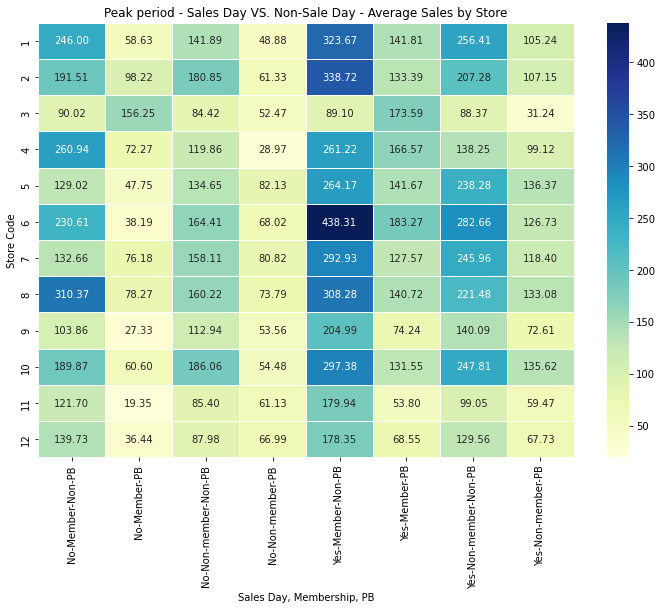

In [107]:
import matplotlib.pyplot as plt
import seaborn as sns

# create heatmap 
plt.figure(figsize=(12, 8))
sns.heatmap(store_avg_sale_table, cmap='YlGnBu', annot=True, fmt=".2f", linewidths=.5)

plt.title('Peak period - Sales Day VS. Non-Sale Day - Average Sales by Store')
plt.xlabel('Sales Day, Membership, PB')
plt.ylabel('Store Code')

plt.show()

In [113]:
# Peak period - Sales Day VS. Non-Sale Day - PB VS Non-PB

def calculate_total_sales(df):
    return df['SALES'].sum()

# Sales by 'SALES_DAY', '門店編碼', 'PB' 
result = peak_df.groupby(['SALES_DAY', '門店編碼', 'PB']).apply(calculate_total_sales).reset_index(name='SALES')
store_sales_table = result.pivot_table(index='門店編碼', columns=['SALES_DAY', 'PB'], values='SALES')

store_sales_table

SALES_DAY        No               Yes         
PB           Non-PB      PB    Non-PB       PB
門店編碼                                          
1          263199.8  5170.2  813577.4  46294.3
2           97098.2  3570.6  357568.9  24750.0
3           21440.6  2929.1   24701.0   2263.5
4           42407.6  1360.0  100296.8   9957.2
5           57139.3  2093.3  247154.6  21226.2
6           57671.9  2987.9  254297.4  18754.1
7          147809.7  6178.6  521814.1  30938.5
8          141145.4  4065.1  292948.6  23588.4
9           46493.2  2175.3  127792.3   7980.9
10          48614.7  1114.1  145220.0   9761.8
11          31782.6  2400.4   42785.2   3568.1
12          37945.6  2386.0   86530.2   5789.0

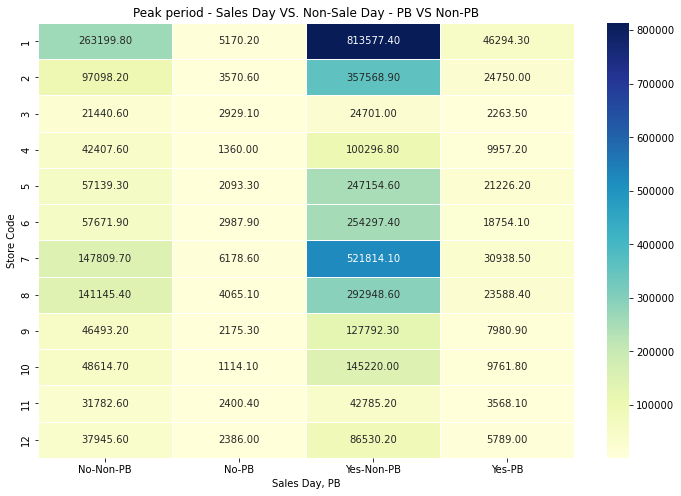

In [115]:
plt.figure(figsize=(12, 8))
sns.heatmap(store_sales_table, cmap='YlGnBu', annot=True, fmt=".2f", linewidths=.5)

plt.title('Peak period - Sales Day VS. Non-Sale Day - PB VS Non-PB')
plt.xlabel('Sales Day, PB')
plt.ylabel('Store Code')

plt.show()

#### 2.4.2.2 Non-Peak Period

In [116]:
# Non-Peak period - Sales Day VS. Non-Sale Day - ave sales 
nonpeak_df = combined_df[combined_df['PEAK'] == 'No']

# Sales by 'SALES_DAY', '門店編碼', 'PB' 
result = nonpeak_df.groupby(['SALES_DAY', '門店編碼', 'PB']).apply(calculate_total_sales).reset_index(name='SALES')
store_sales_table = result.pivot_table(index='門店編碼', columns=['SALES_DAY', 'PB'], values='SALES')

store_sales_table

SALES_DAY       No               Yes         
PB          Non-PB      PB    Non-PB       PB
門店編碼                                         
1          78003.5  1751.1  219978.6  10237.3
2          26112.3  1827.8   59108.4   5435.8
3           3869.5   833.9    6731.4    243.0
4          33895.9  1120.1   31358.3   4681.8
5          12513.3   630.2   42596.1   4405.5
6           7060.6   620.9   16338.0   1131.5
7          48086.2  1571.7  128310.9   9180.8
8          40096.9  2009.5   83292.8   8607.4
9          18201.0   833.7   50630.9   3777.2
10         20417.1   709.2   55828.6   3060.9
11          7235.1   299.6    5939.7    125.2
12         11139.3  2369.8   20025.0   2811.4

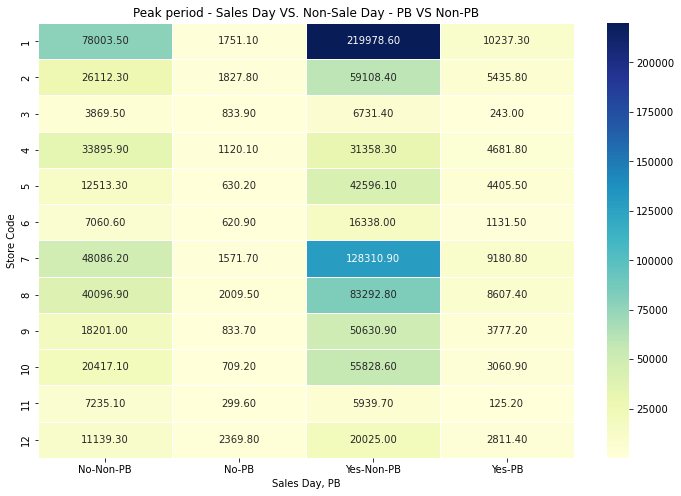

In [117]:
plt.figure(figsize=(12, 8))
sns.heatmap(store_sales_table, cmap='YlGnBu', annot=True, fmt=".2f", linewidths=.5)

plt.title('Peak period - Sales Day VS. Non-Sale Day - PB VS Non-PB')
plt.xlabel('Sales Day, PB')
plt.ylabel('Store Code')

plt.show()